# Let's simulate quantum circuit on gpu!
***Please open this in the play ground!!! ***

### Today, we use **CuPy** module for using gpu easily from Python. CuPy is module for using CUDA which is IDE for GPU coding.[Cupy](https://cupy.chainer.org/)

You can run the script with Ctrl-Shift

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

If there are some gpu name, it works.
Let me know if there are no gpu devices.('/device:GPU:0' is fine)

Install cupy and qiskit(this may take a little time)

In [0]:
!curl https://colab.chainer.org/install | sh -
! pip install qiskit  # to make circuit figure

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5337      0 --:--:-- --:--:-- --:--:--  5337
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!
    100% |████████████████████████████████| 7.3MB 5.7MB/s 
    100% |████████████████████████████████| 18.5MB 2.0MB/s 
    100% |████████████████████████████████| 2.0MB 11.6MB/s 
    100% |████████████████████████████████| 5.9MB 8.0MB/s 
    100% |████████████████████████████████| 61kB 22.7MB/s 
    100% |████████████████████████████████| 51kB 23.9MB/s 
    100% |████████████████████████████████| 51kB 22.3MB/s 
    100% |███████

In [0]:
import cupy as cp 
import numpy as np
from pprint import pprint
from scipy.linalg import expm  # Thank you Shingy!
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit  # To visualize circuit

/usr/local/lib/python3.6/dist-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


We can use GPU only changing **np** to **cp**!!  
## Compare CPU with GPU.

I prepared basic operations for one and two qubit gate.
###CPU

In [0]:
# These are quantum gates on cpu. (j is imaginary unit)
id_cpu = np.array(((1, 0), (0, 1)))
x_cpu = np.array(((0, 1), (1, 0)))
y_cpu = np.array(((0, -1j), (1j, 0)))
z_cpu = np.array(((1, 0), (0, -1)))
h_cpu = 1/np.sqrt(2)*np.array(((1, 1), (1, -1)))
cnot_cpu = np.array(((1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0)))

def u1_cpu(theta):
  return np.array(((1, 0), (0, np.exp(-1j*theta))))

def cu1_cpu(theta, control, target, qubits=10):
  if control == target:
    raise Exception("control and target must be different number.")
  if control < 0 or target < 0:
    raise Exception("control and target must be positive.")
  ui1 = u1_cpu(theta)
  
  I = np.identity(2**qubits)
  
  # Making hamiltonian of cu1
  u1_c = [id_cpu for _ in range(qubits)]
  u1_c[control] = ui1
  u1_control = u1_c[0]
  for i in u1_c[1:]:
    u1_control = np.kron(u1_control, i) 
  
  u1_t = [id_cpu for _ in range(qubits)]
  u1_t[target] = ui1
  u1_target = u1_t[0]
  for i in u1_t[1:]:
    u1_target = np.kron(u1_target, i)
    
  # Hamiltonian of cu1 gate.
  H_cu1 = 1/(2**(qubits-1))*(I - u1_control - u1_target + np.dot(u1_control, u1_target))
  
  diag = np.exp(np.diag(H_cu1))
#   diag = expm(H_cu1) # in this system, matrix is diagonal. this function was not needed...
  
  return np.diag(diag)

def hcpu(target, qubits=10):
  if target < 0:
    raise Exception("target qubit must be positive")
    
  h1 = [id_cpu for _ in range(qubits)]
  h1[target] = h_cpu
  
  h_t = h1[0]
  for i in h1[1:]:
    h_t = np.kron(h_t, i)
    
  return h_t

###GPU


In [0]:
# These are quantum gates on gpu.
id_gpu = cp.array(((1, 0), (0, 1)))
x_gpu = cp.array(((0, 1), (1, 0)))
y_gpu = cp.array(((0, -1j), (1j, 0)))
z_gpu = cp.array(((1, 0), (0, -1)))
h_gpu = 1/cp.sqrt(2)*cp.array(((1, 1), (1, -1)))
cnot_gpu = cp.array(((1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0)))

def u1_gpu(theta):
  # if theta = pi, then this gate is equal to controlled-Z gate.
  return cp.array(((1, 0), (0, np.exp(-1j*theta))))

def cu1_gpu(theta, control, target, qubits=10):
  if control == target:
    raise Exception("control and target must be different number.")
  if control < 0 or target < 0:
    raise Exception("control and target must be positive.")
  ui1 = u1_gpu(theta)
  
  I = cp.identity(2**qubits)
 
  # Making hamiltonian of cu1
  u1_c = [id_gpu for _ in range(qubits)]
  u1_c[control] = ui1
  u1_control = u1_c[0]
  for i in u1_c[1:]:
    u1_control = cp.kron(u1_control, i) 
  
  u1_t = [id_gpu for _ in range(qubits)]
  u1_t[target] = ui1
  u1_target = u1_t[0]
  for i in u1_t[1:]:
    u1_target = cp.kron(u1_target, i)
    
  # Hamiltonian of cu1 gate.
  H_cu1 = 1/(2**(qubits-1))*(I - u1_control - u1_target + cp.dot(u1_control, u1_target))
  
  diag = cp.exp(cp.diag(H_cu1))  
#   diag = expm(H_cu1)
  
  return cp.diag(diag)

def hgpu(target, qubits=10):
  if target < 0:
    raise Exception("target qubit must be positive")
    
  h1 = [id_gpu for _ in range(qubits)]
  h1[target] = h_gpu
  
  h_t = h1[0]
  for i in h1[1:]:
    h_t = cp.kron(h_t, i)
    
  return h_t

In [0]:
# To check execution time!
import time

## 2 Qubits


###Qiskit (just making circuit figure.)
**Making quantum entanglement.  **



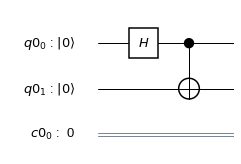

In [0]:
q = QuantumRegister(2)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.h(q[0])
qc.cx(q[0], q[1])
qc.draw(output="mpl")

###CPU

***I excluded  the time making multi qubits matrix from 1 qubit.***


In [0]:
H = np.kron(h_cpu, id_cpu)  # Tensor product of h gate and id gate (h gate for first qubit) 

start = time.time()  # timer start

initial_state = np.array(((1, 0, 0, 0)))  # Initial state is |00>
  
output = np.dot(np.dot(initial_state, H), cnot_cpu)  #  Making quantum entanglement.

exectime = time.time() - start  # timer stop

pprint(output)
print("time :", exectime)

array([0.70710678, 0.        , 0.        , 0.70710678])
time : 0.00014138221740722656


###GPU

In [0]:
H = cp.kron(h_gpu, id_gpu)  # Tensor product of h gate and id gate (h gate for first qubit) 

start = time.time()  # timer start

initial_state = cp.array(((1, 0, 0, 0)))  # Initial state is |00>
  
output = cp.dot(cp.dot(initial_state, H), cnot_gpu)  #  Making quantum entanglement.

exectime = time.time() - start  # timer stop

pprint(output)
print("time :", exectime)

array([0.70710678, 0.        , 0.        , 0.70710678])
time : 0.0006346702575683594


Execution time of GPU simulator is longer than CPU, right?  
How about this?


## 10 Qubit



Making **Quantum Fourier Transform.**


### Qiskit (just making circuit figure)


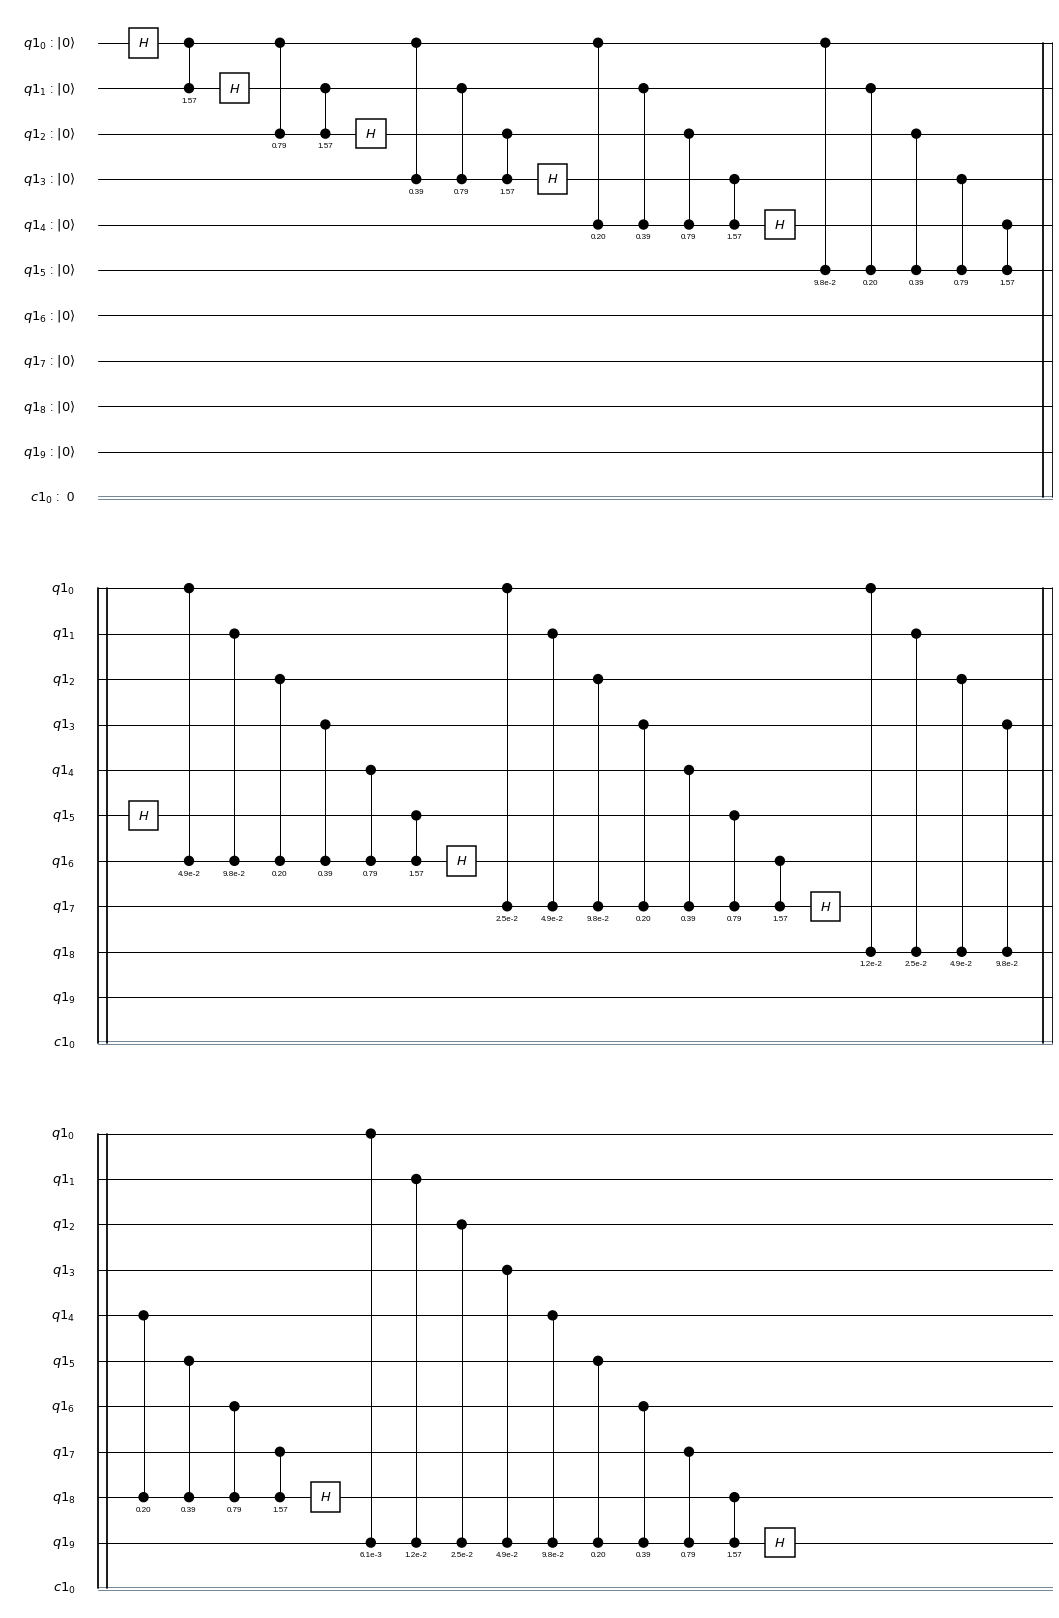

In [0]:
q = QuantumRegister(10)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for i in range(10):
  qc.h(q[i])
  for j in range(i+1, 10):
    qc.cu1((2*np.pi/(2**(j-i+1))), q[i], q[j])
qc.draw(output="mpl")

###CPU

This takes a little time. please wait...

In [0]:
  initial_state = np.zeros(2**10)
  initial_state[0] = 1  # making initial state |00...00>
  
  start = time.time()  # start timer
  
  state = initial_state
  for c in range(10):
    state = np.dot(state, hcpu(c))
    for t in range(c+1, 10):
      state = np.dot(state, cu1_cpu(2*np.pi/(2**(t-c+1)), c, t))
      
  exectime = time.time() - start  # stop timer
  
  print(exectime)
  print(state)

22.311917304992676
[0.03125+0.j 0.03125+0.j 0.03125+0.j ... 0.03125+0.j 0.03125+0.j
 0.03125+0.j]


###GPU

In [0]:
  initial_state = cp.zeros(2**10)
  initial_state[0] = 1  # making initial state |00...00>
  
  start = time.time()  # start timer
  
  state = initial_state
  for c in range(10):
    state = cp.dot(state, hgpu(c))
    for t in range(c+1, 10):
      state = cp.dot(state, cu1_gpu(2*np.pi/(2**(t-c+1)), c, t))
      
  exectime = time.time() - start  # stop timer
  print(exectime)
  print(state)

4.798273801803589
[0.03125+0.j 0.03125+0.j 0.03125+0.j ... 0.03125+0.j 0.03125+0.j
 0.03125+0.j]


##Appendix

Where is the threashold of cpu and gpu simulation?

In [0]:
qubit = [2, 3, 4, 5, 6, 7, 8, 9, 10]
exec_time_cpu = []
exec_time_gpu = []

**CPU**

In [0]:
for q in qubit:    
    initial_state = np.zeros(2**q)
    initial_state[0] = 1
    start = time.time()
    state = initial_state
    for c in range(q):
      state = np.dot(state, hcpu(c, qubits=q))
      for t in range(c+1, q):
        state = np.dot(state, cu1_cpu(1/(2**(t-c+1)), c, t, qubits=q))
    exectime = time.time() - start
    exec_time_cpu.append(exectime)
#     print(exectime)
#     print(state)
print("done!")
  

done!


**GPU**

In [0]:
  for q in qubit:
    initial_state = cp.zeros(2**q)
    initial_state[0] = 1
    start = time.time()
    state = initial_state
    for c in range(q):
      state = cp.dot(state, hgpu(c, qubits=q))
      for t in range(c+1, q):
        state = cp.dot(state, cu1_gpu(1/(2**(t-c+1)), c, t, qubits=q))
    exectime = time.time() - start
    exec_time_gpu.append(exectime)
#     print(exectime)
#     print(state)
print("done!")


done!


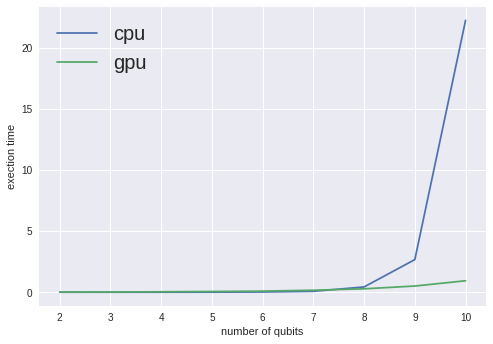

In [0]:
import matplotlib.pyplot as plt

plt.plot(qubit, exec_time_cpu, label="cpu")
plt.plot(qubit, exec_time_gpu, label="gpu")
plt.xlabel("number of qubits")
plt.ylabel("exection time")
plt.legend(fontsize=20)

## Acknowledgement
 Shingy : Thank you for telling me the function scipy.expm()!(twitter:@SIG_TIG)

©️2019 Ryosuke Satoh